# Phase 1: Problem Definition
## Understand Objectives
### Problem Statement
_To analyze and model the relationship between specific audio features and song popularity, aiming to identify the most influential features and develop a robust predictive model, thereby providing actionable insights for the music industry and contributing to academic research._
### Success Criteria
- Achieving an adjusted R-squared > 0.8.
- RMSE and MAE below acceptable thresholds established after data exploration.
- Statistical significance of key predictors at the 0.05 significance level.

# Phase 2: Data Acquisition and Understanding

In [974]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, pearsonr, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from package import plot_histogram_and_boxplot, clean_test_set

import datetime
import joblib
from copy import deepcopy

## Data Collection
We have collected a raw dataset named ["Most Streamed Spotify Songs 2023"](https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023) on Kaggle.

## Data Understanding

### Explore Data Structure

In [975]:
# Data loading
spotify_2023_df = pd.read_csv('../data/raw/spotify-2023.csv', encoding='latin-1')
spotify_2023_df.head()


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [976]:
spotify_2023_df.tail()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,...,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,...,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,...,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612,29,...,97,C#,Major,82,67,77,8,0,12,5
952,Alone,Burna Boy,1,2022,11,4,782,2,96007391,27,...,90,E,Minor,61,32,67,15,0,11,5


In [977]:
spotify_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [978]:
spotify_2023_df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


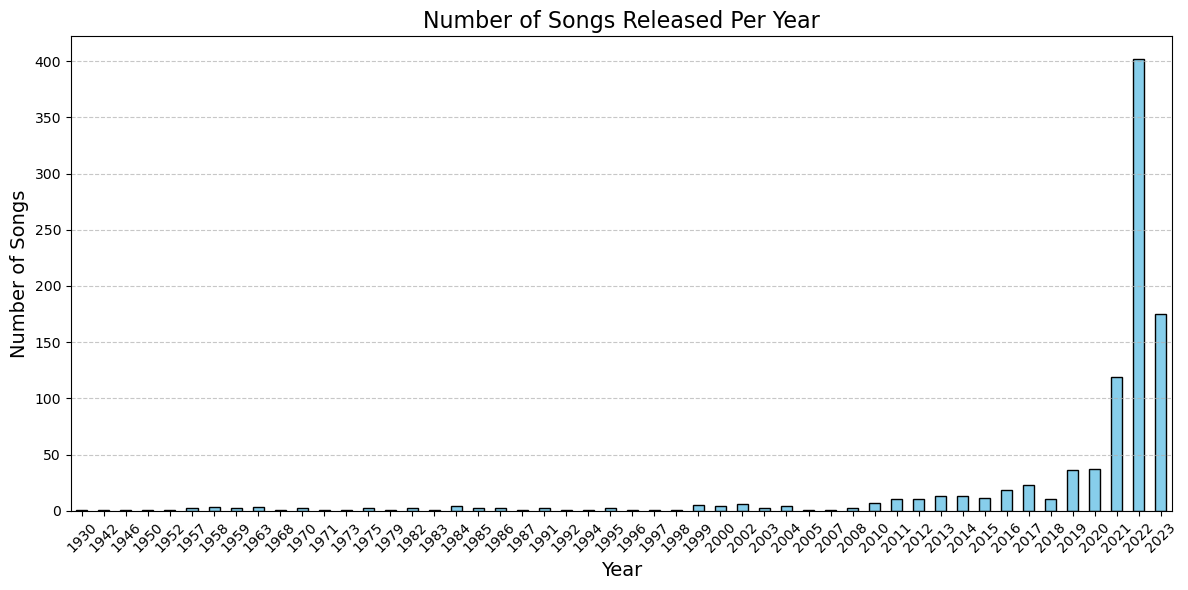

In [979]:
def plot_songs_per_year(dataset: pd.DataFrame, year_column: str = 'released_year') -> None:
    """
    Plots a histogram showing the number of songs released per year.

    Parameters:
    dataset (DataFrame): The dataset containing the release year information.
    year_column (str): The column name representing the release year.

    Returns:
    None
    """
    plt.figure(figsize=(12, 6))
    dataset[year_column].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Number of Songs Released Per Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Songs', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_songs_per_year(spotify_2023_df, year_column='released_year')


Chart shows that songs are heavily concentrated after 2010, the time when online music platforms became popular.

### Split the Data in Train and Test Set

The purpose of this is to simulate the process of using the model in real life. The data inside test_set is an embodiment of data given in real life.

In [980]:
raw_data_path = '../data/raw'

In [981]:
# # Split the data into training and test sets
# # Uncomment this when proposing
train_set, test_set = train_test_split(spotify_2023_df, test_size=0.2, random_state=200)

# # Save the train_set and test_set in .csv files

train_set.to_csv(f'{raw_data_path}/train_set.csv', index=False)
test_set.to_csv(f'{raw_data_path}/test_set.csv', index=False)

In [982]:
# Read the train set
train_set = pd.read_csv(f"{raw_data_path}/train_set.csv",)
train_set.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,All Too Well (10 Minute Version) (Taylor's Ver...,Taylor Swift,1,2021,11,12,4635,5,583687007,50,...,93,NaN,Major,63,21,52,28,0,9,3
1,Driving Home for Christmas - 2019 Remaster,Chris Rea,1,1986,1,1,888,0,429504768,50,...,180,A,Major,51,87,58,36,0,18,4
2,It'll Be Okay,Shawn Mendes,1,2021,12,1,1950,0,287201015,56,...,78,G,Major,40,7,29,62,0,9,3
3,Murder In My Mind,Kordhell,1,2022,1,21,2459,20,448843705,20,...,120,A#,Major,71,57,97,1,0,13,11
4,SOS,SZA,1,2022,12,9,827,0,73981293,6,...,119,G,Minor,51,51,66,67,0,9,23


In [983]:
train_set.shape

(476, 24)

### Drop Unimportant Columns

Based on the problem that we're trying to model, there're columns that we don't need.

To predict the streams of an un-released track, these columns are things we don't need:
- `in_spotify_playlists`
- `in_spotify_charts`
- `in_apple_playlists`
- `in_apple_charts`
- `in_apple_charts`
- `in_deezer_playlists`
- `in_deezer_charts`
- `in_shazam_charts`

In [984]:
# Define the list of columns
columns_to_drop = [
    'in_spotify_playlists',
    'in_spotify_charts',
    'in_apple_playlists',
    'in_apple_charts',
    'in_deezer_playlists',
    'in_deezer_charts',
    'in_shazam_charts',
]

# Drop those columns
train_set = train_set.drop(columns=columns_to_drop)

# Check the result
train_set.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,All Too Well (10 Minute Version) (Taylor's Ver...,Taylor Swift,1,2021,11,12,583687007,93,NaN,Major,63,21,52,28,0,9,3
1,Driving Home for Christmas - 2019 Remaster,Chris Rea,1,1986,1,1,429504768,180,A,Major,51,87,58,36,0,18,4
2,It'll Be Okay,Shawn Mendes,1,2021,12,1,287201015,78,G,Major,40,7,29,62,0,9,3
3,Murder In My Mind,Kordhell,1,2022,1,21,448843705,120,A#,Major,71,57,97,1,0,13,11
4,SOS,SZA,1,2022,12,9,73981293,119,G,Minor,51,51,66,67,0,9,23


### Rename Columns

In [985]:
need_to_be_removed_chars = ['_', '%']

# Remove the characters from the column names
train_set.columns = train_set.columns.str.replace('_', ' ')
train_set.columns = train_set.columns.str.replace('%', 'percentage')

# Check the result
train_set.head()

,track name,artist(s) name,artist count,released year,released month,released day,streams,bpm,key,mode,danceability percentage,valence percentage,energy percentage,acousticness percentage,instrumentalness percentage,liveness percentage,speechiness percentage
0,All Too Well (10 Minute Version) (Taylor's Ver...,Taylor Swift,1,2021,11,12,583687007,93,NaN,Major,63,21,52,28,0,9,3
1,Driving Home for Christmas - 2019 Remaster,Chris Rea,1,1986,1,1,429504768,180,A,Major,51,87,58,36,0,18,4
2,It'll Be Okay,Shawn Mendes,1,2021,12,1,287201015,78,G,Major,40,7,29,62,0,9,3
3,Murder In My Mind,Kordhell,1,2022,1,21,448843705,120,A#,Major,71,57,97,1,0,13,11
4,SOS,SZA,1,2022,12,9,73981293,119,G,Minor,51,51,66,67,0,9,23


### Assess Data Quality

#### Missing Values

In [986]:
train_set.isnull().sum()

track name                      0
artist(s) name                  0
artist count                    0
released year                   0
released month                  0
released day                    0
streams                         0
bpm                             0
key                            47
mode                            0
danceability percentage         0
valence percentage              0
energy percentage               0
acousticness percentage         0
instrumentalness percentage     0
liveness percentage             0
speechiness percentage          0
dtype: int64

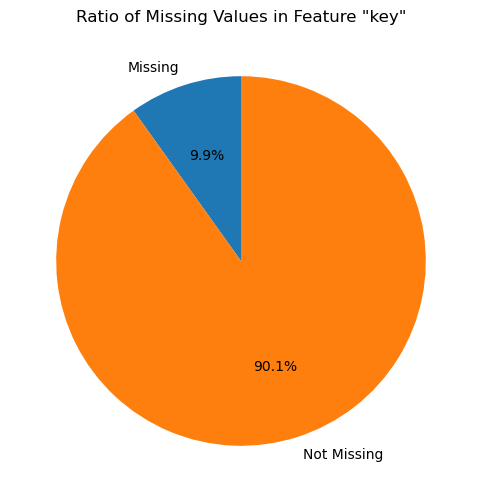

In [987]:
missing_ratio = train_set['key'].isnull().mean()

    # Tạo dữ liệu cho biểu đồ
pie_data = [missing_ratio, 1 - missing_ratio]
labels = ['Missing', 'Not Missing']
    
    # Vẽ biểu đồ pie chart
plt.figure(figsize=(6, 6))
plt.pie(pie_data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Ratio of Missing Values in Feature "key"')
plt.show()

**The missing value rate is less than 10% and there is only missing value in 1 feature, showing that the data is quite clean**

By observation, we can see that there're just some missing values need to be handled. We will tackle these in the substep of handling missing data in Phase 3: Data Preparation.

#### Duplicates

In [988]:
# Drop the duplicated rows
train_set = train_set.drop_duplicates()

- TODO: Report the data shape before and after dropping duplicates.

#### Data Type Conversion

Numerical columns must be numerical columns (of course). Since `streams` column is of type `object`, we need to convert it to numerical type, so that we can process it later.

In [989]:
def is_integer_string(string: str) -> bool:
    if string[0] in ('-', '+'):
        return string[1:].isdigit()
    
    else:
        return string.isdigit()
    
train_set = train_set[train_set['streams'].apply(is_integer_string)]
train_set['streams'] = train_set['streams'].astype('int64')

#### Outliers and Anomalies

In [990]:
# Inspect the data type of each column
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475 entries, 0 to 475
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   track name                   475 non-null    object
 1   artist(s) name               475 non-null    object
 2   artist count                 475 non-null    int64 
 3   released year                475 non-null    int64 
 4   released month               475 non-null    int64 
 5   released day                 475 non-null    int64 
 6   streams                      475 non-null    int64 
 7   bpm                          475 non-null    int64 
 8   key                          428 non-null    object
 9   mode                         475 non-null    object
 10  danceability percentage      475 non-null    int64 
 11  valence percentage           475 non-null    int64 
 12  energy percentage            475 non-null    int64 
 13  acousticness percentage      475 non-nul

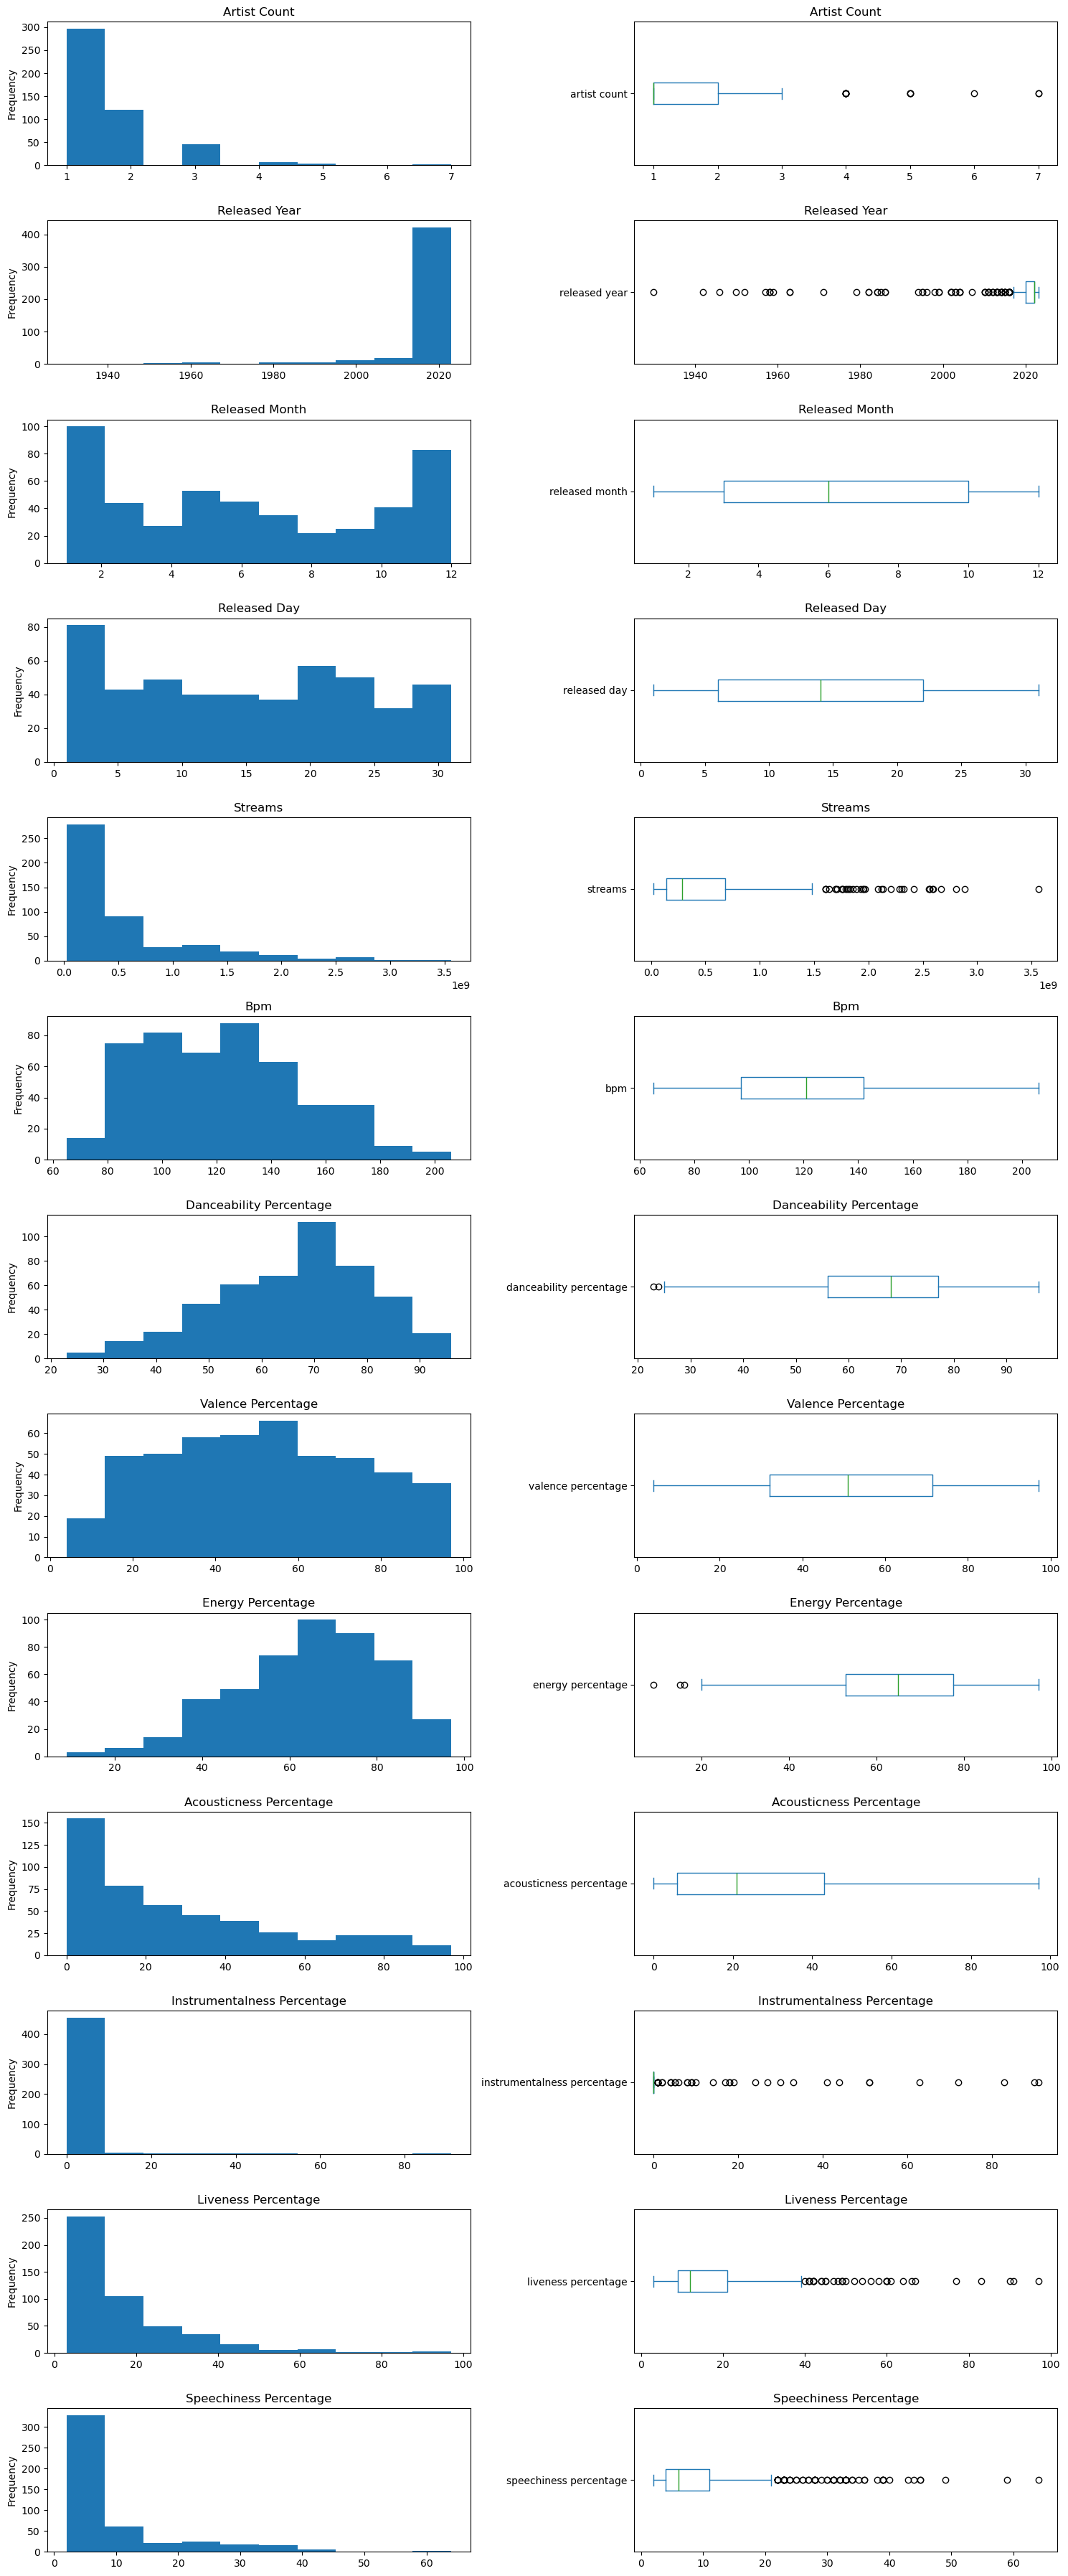

In [991]:
# Get the column name of numerical columns
numerical_columns = train_set.select_dtypes(include=['int64', 'float64']).columns

# For each columns plot a histogram and a boxplot horizontally side by side
fig, axs = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(15, 36))

for i, col in enumerate(numerical_columns):
    train_set[col].plot(kind='hist', ax=axs[i, 0], title=col.title())
    train_set[col].plot(kind='box', ax=axs[i, 1], title=col.title(), vert=False)
    
plt.tight_layout()

Looking at the histogram for the `instrumentalness percentage`, we can (loosely) infer that this column doesn't contain much information that's helpful for the learning process of the models. Therefore, we will drop it.

In [992]:
train_set.drop(columns=['instrumentalness percentage'], inplace=True)

Since music market before 2015 might be different from itself from 2010 and after, songs released before 2015 will be discarded. 

In [993]:
# Eliminate songs released before 2015
train_set = train_set[train_set['released year'] >= 2015]

# Phase 3: Data Preparation

- By observing the histograms and boxplots we have created above, we can see that there're columns have skewed to very skewed distributions. There are also lots of columns with outliers we need to handle. But firstly, we will handle the missing values by imputing or removing them.
- In this dataset, there's only 1 column having missing values we need to handle: the `key` column.
- Since the `key` of a song cannot be infered using information from other songs, we will fill missing keys with `unknown`.

## Data Cleaning

#### Handle Missing Data

In [940]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 475
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   track name               414 non-null    object
 1   artist(s) name           414 non-null    object
 2   artist count             414 non-null    int64 
 3   released year            414 non-null    int64 
 4   released month           414 non-null    int64 
 5   released day             414 non-null    int64 
 6   streams                  414 non-null    int64 
 7   bpm                      414 non-null    int64 
 8   key                      372 non-null    object
 9   mode                     414 non-null    object
 10  danceability percentage  414 non-null    int64 
 11  valence percentage       414 non-null    int64 
 12  energy percentage        414 non-null    int64 
 13  acousticness percentage  414 non-null    int64 
 14  liveness percentage      414 non-null    int64 

In [941]:
train_set['key'] = train_set['key'].fillna("unknown")

- When cleaning the test set, on columns like `key` and `mode`, if there's a value doesn't exist in the train set, we will replace it with `unknown`.

In [942]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 475
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   track name               414 non-null    object
 1   artist(s) name           414 non-null    object
 2   artist count             414 non-null    int64 
 3   released year            414 non-null    int64 
 4   released month           414 non-null    int64 
 5   released day             414 non-null    int64 
 6   streams                  414 non-null    int64 
 7   bpm                      414 non-null    int64 
 8   key                      414 non-null    object
 9   mode                     414 non-null    object
 10  danceability percentage  414 non-null    int64 
 11  valence percentage       414 non-null    int64 
 12  energy percentage        414 non-null    int64 
 13  acousticness percentage  414 non-null    int64 
 14  liveness percentage      414 non-null    int64 

- Okay, now all the missing values were handled. Next, we need to address inconsistencies in the data.

#### Address Inconsistencies

In [943]:
# Before addressing inconsistencies, let's inspect the dataset once.
train_set.head()

,track name,artist(s) name,artist count,released year,released month,released day,streams,bpm,key,mode,danceability percentage,valence percentage,energy percentage,acousticness percentage,liveness percentage,speechiness percentage
0,All Too Well (10 Minute Version) (Taylor's Ver...,Taylor Swift,1,2021,11,12,583687007,93,unknown,Major,63,21,52,28,9,3
2,It'll Be Okay,Shawn Mendes,1,2021,12,1,287201015,78,G,Major,40,7,29,62,9,3
3,Murder In My Mind,Kordhell,1,2022,1,21,448843705,120,A#,Major,71,57,97,1,13,11
4,SOS,SZA,1,2022,12,9,73981293,119,G,Minor,51,51,66,67,9,23
5,NEW MAGIC WAND,"Tyler, The Creator",2,2019,5,16,461437791,140,F,Minor,62,46,73,10,67,11


In [944]:
# For all string columns, standardize the text by converting them into lowercase
# and remove leading and trailing whitespaces
string_columns = train_set.select_dtypes(include=['object']).columns

for col in string_columns:
    train_set[col] = train_set[col].str.lower().str.strip()
    
# Check the result
train_set.head()

,track name,artist(s) name,artist count,released year,released month,released day,streams,bpm,key,mode,danceability percentage,valence percentage,energy percentage,acousticness percentage,liveness percentage,speechiness percentage
0,all too well (10 minute version) (taylor's ver...,taylor swift,1,2021,11,12,583687007,93,unknown,major,63,21,52,28,9,3
2,it'll be okay,shawn mendes,1,2021,12,1,287201015,78,g,major,40,7,29,62,9,3
3,murder in my mind,kordhell,1,2022,1,21,448843705,120,a#,major,71,57,97,1,13,11
4,sos,sza,1,2022,12,9,73981293,119,g,minor,51,51,66,67,9,23
5,new magic wand,"tyler, the creator",2,2019,5,16,461437791,140,f,minor,62,46,73,10,67,11


In [945]:
# Store the unique values of the `key` and `mode` column
unique_keys = list(train_set['key'].unique())
print(unique_keys)

unique_modes = list(train_set['mode'].unique())
print(unique_modes)

['unknown', 'g', 'a#', 'f', 'g#', 'd', 'd#', 'c#', 'b', 'a', 'f#', 'e']
['major', 'minor']


Since we need to preserve the original train set for later use, we will make a copy of it. 

In [946]:
# Create a deepcopy of train_set, for later use
raw_train_set = deepcopy(train_set)

### Handle Outliers

In [947]:
# Loop over numerical columns, calculate IQR and the percentage of outliers
numerical_columns = train_set.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    q1 = train_set[col].quantile(0.25)
    q3 = train_set[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    n_outliers = ((train_set[col] < lower_bound) | (train_set[col] > upper_bound)).sum()
    perc_outliers = (n_outliers / train_set.shape[0]) * 100
    
    print(f'{col} -- {perc_outliers:.2f}%')

artist count -- 2.66%
released year -- 13.77%
released month -- 0.00%
released day -- 0.00%
streams -- 10.63%
bpm -- 0.24%
danceability percentage -- 0.48%
valence percentage -- 0.00%
energy percentage -- 0.48%
acousticness percentage -- 0.00%
liveness percentage -- 6.76%
speechiness percentage -- 14.25%


Because the proportion of outliers in these above columns are not significant, we think it's safe to drop all of them.

In [948]:
# Loop over numerical columns, calculate IQR and remove outliers
for col in numerical_columns:
    q1 = train_set[col].quantile(0.25)
    q3 = train_set[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    train_set = train_set[(train_set[col] >= lower_bound) & (train_set[col] <= upper_bound)]
    
# Check the result
train_set.shape

(248, 16)

In [949]:
# Get numerical columns
numerical_columns = train_set.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['artist count', 'released year', 'released month', 'released day',
       'streams', 'bpm', 'danceability percentage', 'valence percentage',
       'energy percentage', 'acousticness percentage', 'liveness percentage',
       'speechiness percentage'],
      dtype='object')

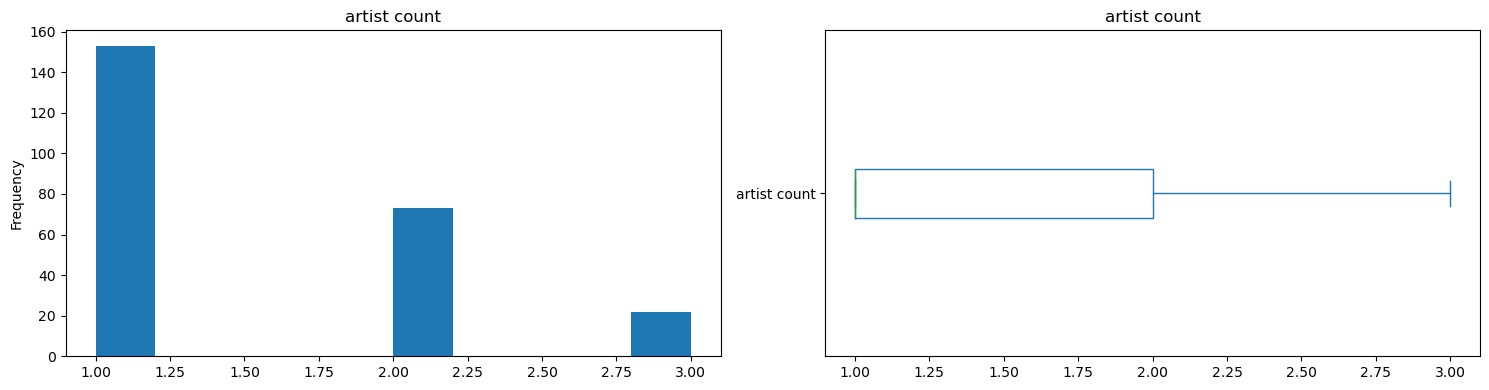

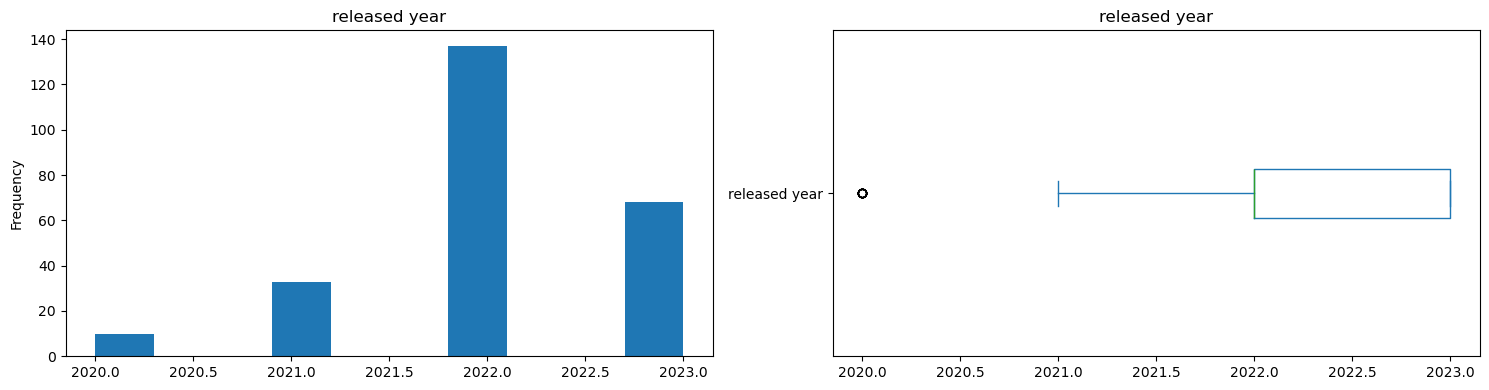

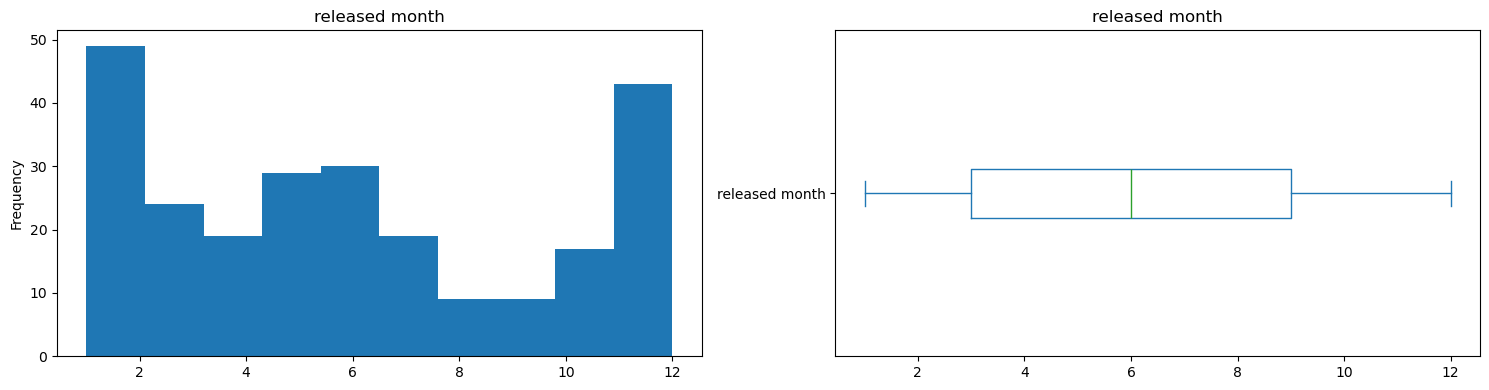

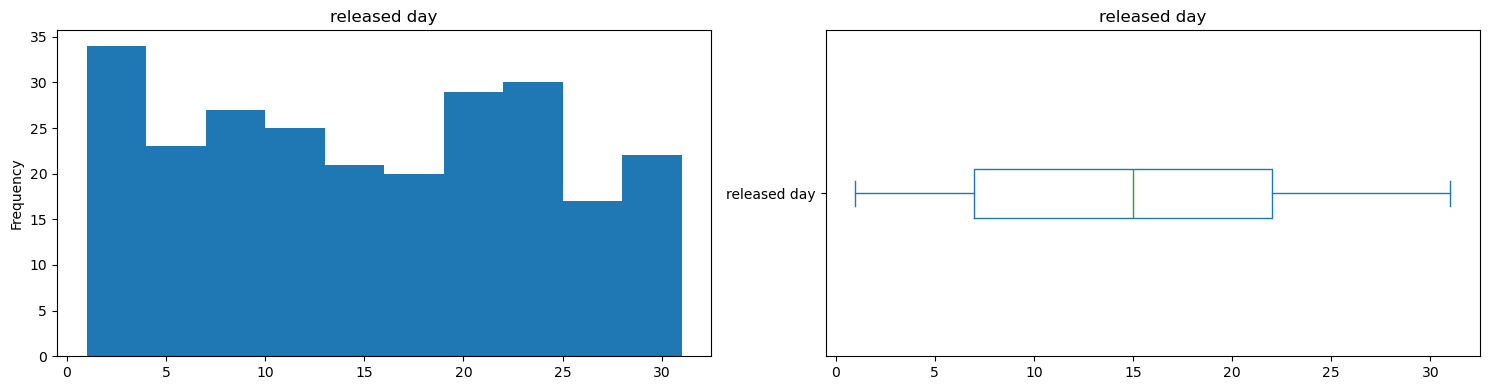

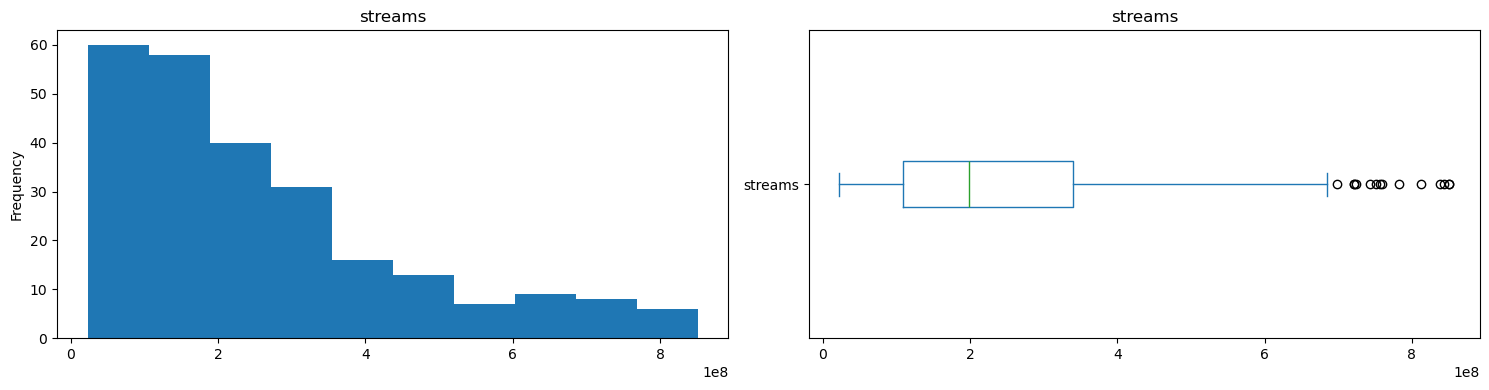

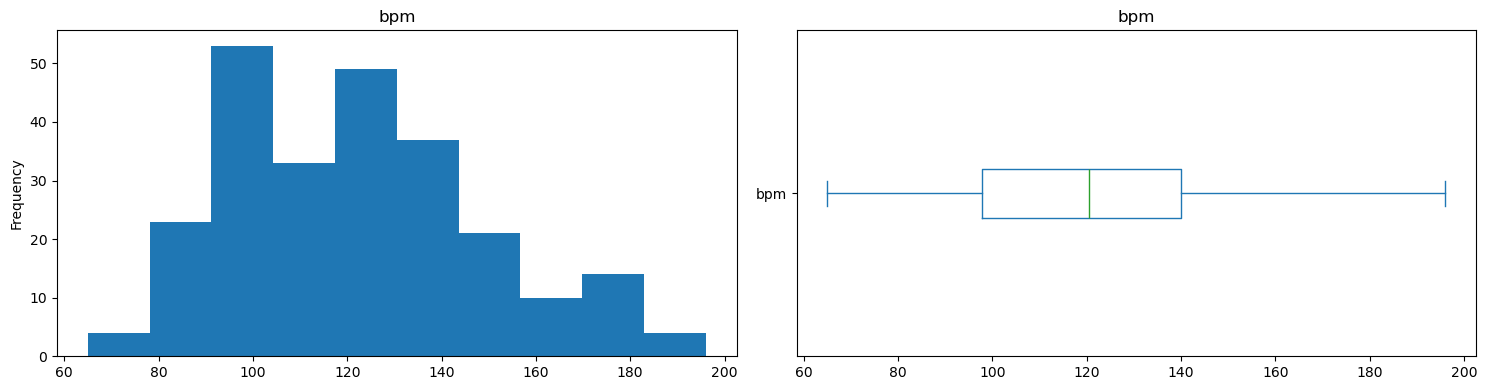

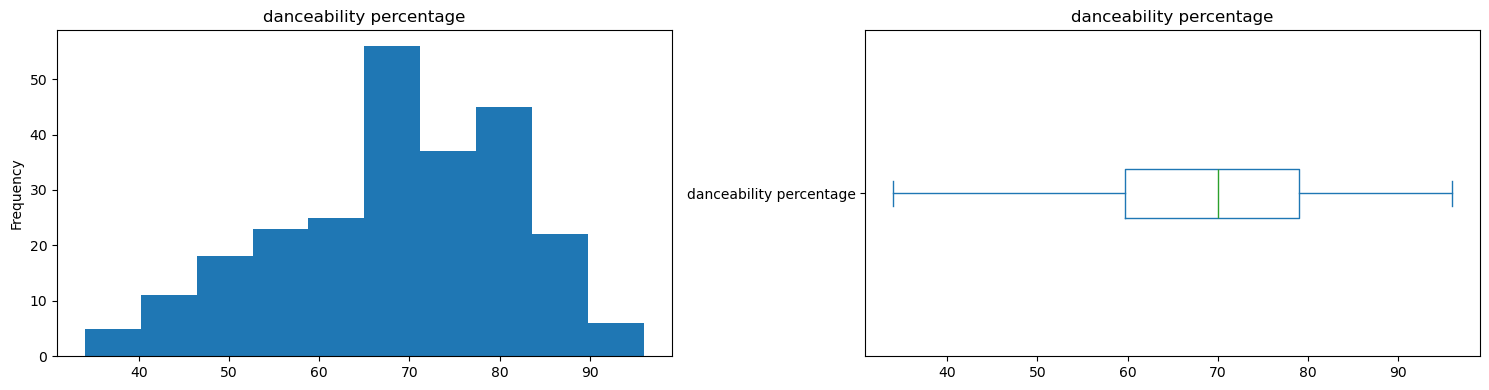

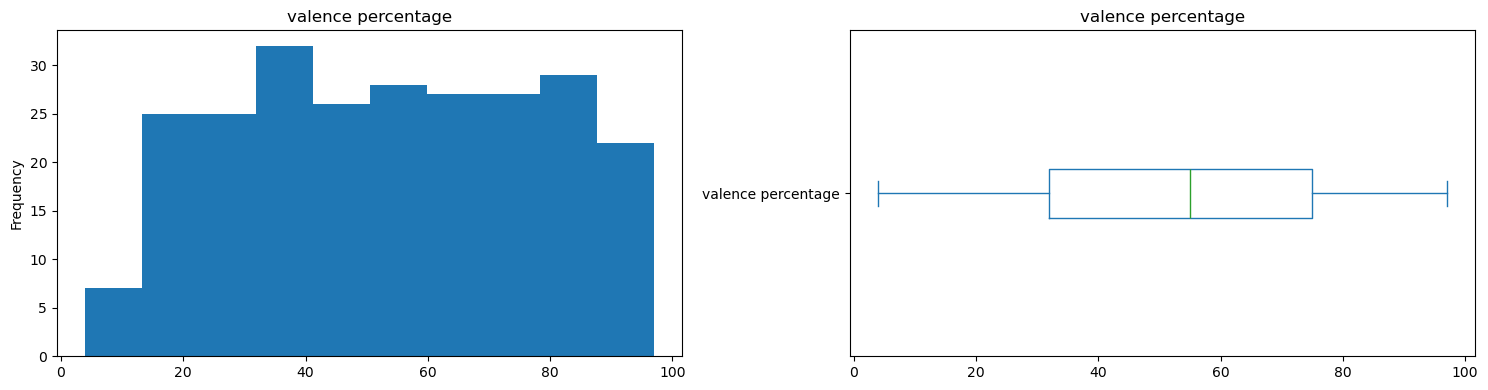

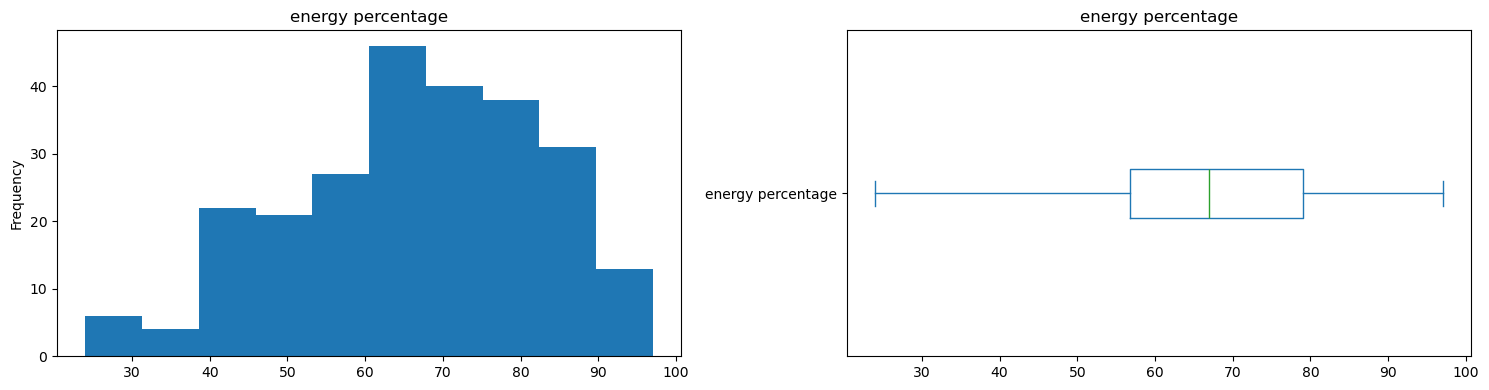

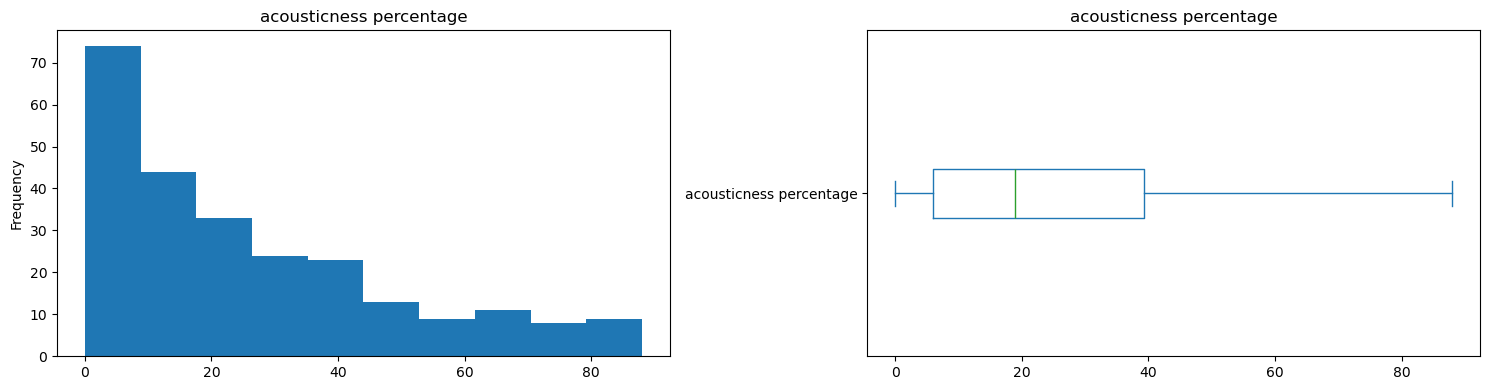

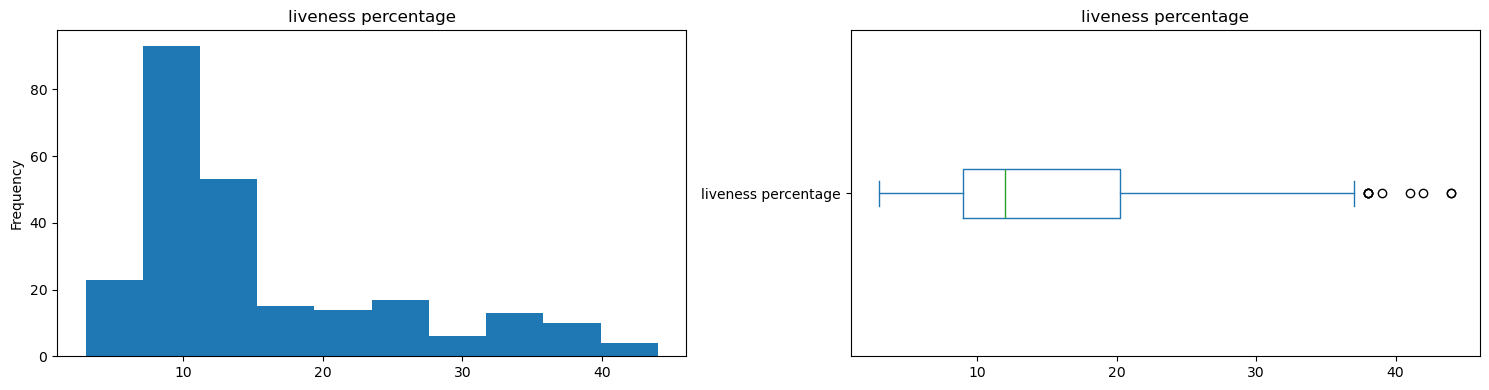

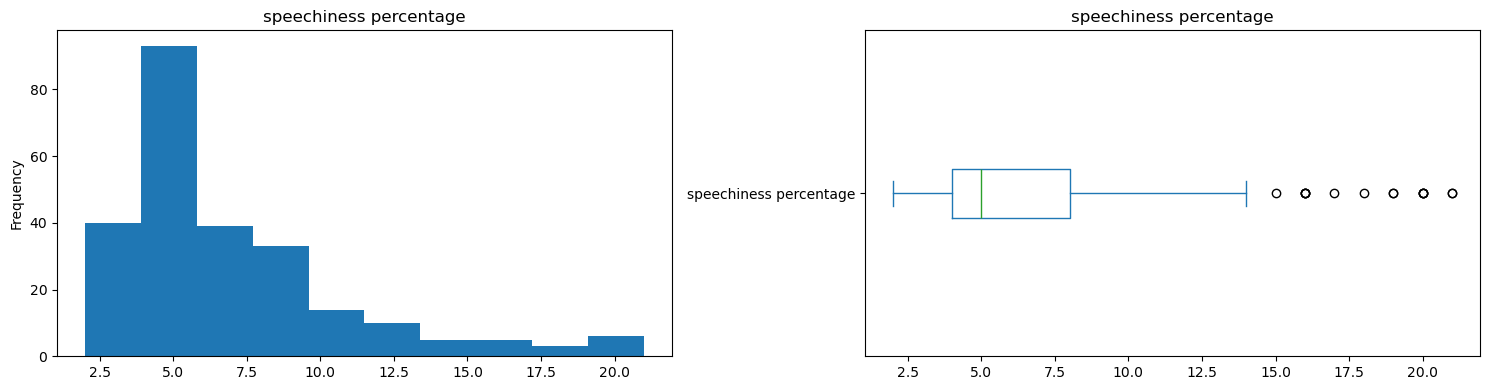

In [950]:

# Plot histogram and boxplot for numerical columns
for col in numerical_columns:
    plot_histogram_and_boxplot(train_set, col)

At this point, most of the columns are outlier-free.

## Data Transformation

### Encoding Categorical Variables

Now the `train_set` is cleaned. Next, we need to perform some transformation on the dataset to help the models easily learn the patterns of the data later.

In [951]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 474
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   track name               248 non-null    object
 1   artist(s) name           248 non-null    object
 2   artist count             248 non-null    int64 
 3   released year            248 non-null    int64 
 4   released month           248 non-null    int64 
 5   released day             248 non-null    int64 
 6   streams                  248 non-null    int64 
 7   bpm                      248 non-null    int64 
 8   key                      248 non-null    object
 9   mode                     248 non-null    object
 10  danceability percentage  248 non-null    int64 
 11  valence percentage       248 non-null    int64 
 12  energy percentage        248 non-null    int64 
 13  acousticness percentage  248 non-null    int64 
 14  liveness percentage      248 non-null    int64 

The `mode` column is encoded as follows:
- Unknown: 0
- Major: 1
- Minor: 2

In [952]:
train_set['mode'] = (train_set['mode']
                    .replace('unknown', 0)
                    .replace('major', 1)
                    .replace('minor', 2))

/tmp/ipykernel_200058/1629544789.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('minor', 2))


The `key` mode is encoded as follows:
1. Convert the key into a numerical format: Assign a numerical index to each key: C=0, C#=1, D=2, ..., A#=10, B=11.
2. Apply sine and cosine transformations: Use the formulas: $$x = \sin(\frac{2 \pi k}{12}), \quad y = \cos(\frac{2 \pi k}{12})$$ where k is the numerical index of the key.
3. Encoding the known and unknown keys:
- For known keys: Set the indicator to 0
- For unknown keys: Set the indicator to 1, and set sine and cosine values to 0
4. Assign the sine as $x$, cosine as $y$, and the indicator as above.

In [953]:
all_keys = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b', 'unknown']

# Assign indices to known keys
key_to_index = {key: i for i, key in enumerate(all_keys[:-1])}

# Encode function
def encode_key(key):
    if key == 'unknown':
        return 0.0, 0.0, 1.0  # Unknown key encoding
    index = key_to_index[key]
    sine = np.sin(2 * np.pi * index / 12)
    cosine = np.cos(2 * np.pi * index / 12)
    return sine, cosine, 0.0  # Known key encoding

# Encode all keys
encoded_keys = {key: encode_key(key) for key in all_keys}

# Convert to DataFrame
keys_df = pd.DataFrame(encoded_keys, index=['sine', 'cosine', 'unknown']).sort_index().T
keys_df

,cosine,sine,unknown
c,1.000000e+00,0.000000e+00,0.0
c#,8.660254e-01,5.000000e-01,0.0
d,5.000000e-01,8.660254e-01,0.0
d#,6.123234e-17,1.000000e+00,0.0
e,-5.000000e-01,8.660254e-01,0.0
f,-8.660254e-01,5.000000e-01,0.0
f#,-1.000000e+00,1.224647e-16,0.0
g,-8.660254e-01,-5.000000e-01,0.0
g#,-5.000000e-01,-8.660254e-01,0.0
a,-1.836970e-16,-1.000000e+00,0.0


In [954]:
train_set['key sine'] = train_set['key'].apply(lambda x: encoded_keys[x][0])
train_set['key cosine'] = train_set['key'].apply(lambda x: encoded_keys[x][1])
train_set['key unknown'] = train_set['key'].apply(lambda x: encoded_keys[x][2])
# Drop the original key column, as it is no longer needed
train_set.drop(columns=['key'], inplace=True)

In [955]:
# Check the result
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 474
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               248 non-null    object 
 1   artist(s) name           248 non-null    object 
 2   artist count             248 non-null    int64  
 3   released year            248 non-null    int64  
 4   released month           248 non-null    int64  
 5   released day             248 non-null    int64  
 6   streams                  248 non-null    int64  
 7   bpm                      248 non-null    int64  
 8   mode                     248 non-null    int64  
 9   danceability percentage  248 non-null    int64  
 10  valence percentage       248 non-null    int64  
 11  energy percentage        248 non-null    int64  
 12  acousticness percentage  248 non-null    int64  
 13  liveness percentage      248 non-null    int64  
 14  speechiness percentage   248 no

### Feature Scaling

By observing the histograms above, there're some points we can infer:
- We don't need to do feature scaling on the `artist count` column because we think it's better to keep it as it is.
- `released day`, `released month` and `released year` will not be done feature-scaling on, since those can be used to show how releasing date can affect a song popularity.
- For columns having their shape close to be bell-shaped, we can apply `StandardScaler()` on them. Those columns are: `bpm`, `danceability percentage`, `valence percentage`, `energy percentage`.
- For columns being heavily right-skewed, we can apply Box-Cox transformation on them. Those columns are: `acousticness percentage`, `liveness percentage`, `speechiness percentage`.
- All transformations that are performed on the target feature - which is the `streams` column - need to be reversible.

In [956]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 0 to 474
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               248 non-null    object 
 1   artist(s) name           248 non-null    object 
 2   artist count             248 non-null    int64  
 3   released year            248 non-null    int64  
 4   released month           248 non-null    int64  
 5   released day             248 non-null    int64  
 6   streams                  248 non-null    int64  
 7   bpm                      248 non-null    int64  
 8   mode                     248 non-null    int64  
 9   danceability percentage  248 non-null    int64  
 10  valence percentage       248 non-null    int64  
 11  energy percentage        248 non-null    int64  
 12  acousticness percentage  248 non-null    int64  
 13  liveness percentage      248 non-null    int64  
 14  speechiness percentage   248 no

We will use exactly this `standard_scaler` and `corr_lambda` for the test_set later to ensure all datapoints are transformed uniformly.

In [957]:
# Create StandardScaler object
standard_scaler = StandardScaler()

columns_to_standard_scale = [
    'bpm',
    'danceability percentage',
    'valence percentage',
    'energy percentage',
]

standard_scaler.fit(train_set[columns_to_standard_scale])
temp_df = pd.DataFrame(standard_scaler
                       .transform(train_set[columns_to_standard_scale]),
                       columns = columns_to_standard_scale)

# We have to reset the index, so that when matching the index, the values are assigned correctly.
# If not, the values will be assigned based on the index of the original dataset, leading to some NaN values.
train_set.reset_index(drop=True, inplace=True)
train_set[columns_to_standard_scale] = temp_df
train_set[columns_to_standard_scale].describe()

,bpm,danceability percentage,valence percentage,energy percentage
count,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02
mean,7.162729e-17,-6.446456e-17,-6.088320e-17,-2.005564e-16
std,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00
min,-2.101053e+00,-2.670206e+00,-2.012187e+00,-2.721492e+00
25%,-8.822290e-01,-6.897256e-01,-8.755543e-01,-6.310855e-01
50%,-3.556528e-02,9.862083e-02,5.810839e-02,2.316382e-02
75%,6.901465e-01,7.908274e-01,8.699890e-01,7.891142e-01
max,2.774242e+00,2.098329e+00,1.763058e+00,1.938040e+00


In [958]:
columns_to_boxcox_transform = [
    'streams',
    'acousticness percentage',
    'liveness percentage',
    'speechiness percentage'
]
# Apply Box-Cox transformation on each column
corr_lambda = {}
for col in columns_to_boxcox_transform:
    train_set[col], lmbda = boxcox(train_set[col] + 1)
    corr_lambda[col] = lmbda
    
# Check the result
train_set[columns_to_boxcox_transform].describe()

,streams,acousticness percentage,liveness percentage,speechiness percentage
count,248.000000,248.000000,248.000000,248.000000
mean,77.259433,4.709435,1.484465,0.990353
std,8.779343,2.539491,0.131257,0.094007
min,57.349817,0.000000,1.009068,0.741417
25%,71.337500,2.625155,1.386512,0.922708
50%,77.485246,4.803245,1.467092,0.971984
75%,83.337469,6.675106,1.592935,1.059664
max,94.312988,9.321329,1.735687,1.178725


In [959]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               248 non-null    object 
 1   artist(s) name           248 non-null    object 
 2   artist count             248 non-null    int64  
 3   released year            248 non-null    int64  
 4   released month           248 non-null    int64  
 5   released day             248 non-null    int64  
 6   streams                  248 non-null    float64
 7   bpm                      248 non-null    float64
 8   mode                     248 non-null    int64  
 9   danceability percentage  248 non-null    float64
 10  valence percentage       248 non-null    float64
 11  energy percentage        248 non-null    float64
 12  acousticness percentage  248 non-null    float64
 13  liveness percentage      248 non-null    float64
 14  speechiness percentage   2

Now all the numerical features have `mean` around `0` and `std` around `1`.

### Feature Engineering

Two custom features we intend to add to are "Mood Index" and "Performance Intensity". However, we have to calculate its correlation with other features to see whether they are needed. The formulas for those are specified below.

In [960]:
def calculate_correlation(col1: pd.Series, col2: pd.Series) -> float:
    """
    This function calculates the Pearson correlation coefficient between two Series.

    Parameters:
    col1 (Series): The name of the first column.
    col2 (Series): The name of the second column.

    Returns:
    float: The Pearson correlation coefficient between the two columns.
    """
    correlation, _ = pearsonr(col1, col2)
    return correlation

In [961]:
numerical_columns = train_set.select_dtypes(include=['int64', 'float64']).columns
mood_index = (train_set['valence percentage'] + train_set['energy percentage']) / 2
performance_intensity = train_set['liveness percentage'] * train_set['energy percentage']

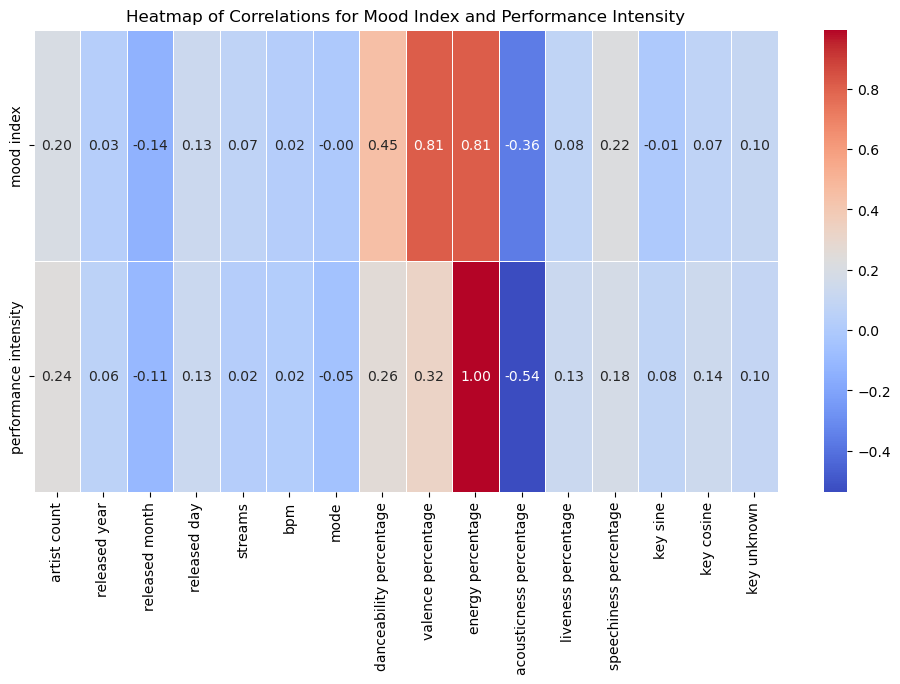

In [962]:
correlation_results = pd.DataFrame(index=['mood index', 'performance intensity'], columns=numerical_columns)
for col in numerical_columns:
    correlation_results.loc['mood index', col] = mood_index.corr(train_set[col])
    correlation_results.loc['performance intensity', col] = performance_intensity.corr(train_set[col])

correlation_results = correlation_results.astype(float)
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_results, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlations for Mood Index and Performance Intensity')
plt.show()


**We see the mood index strongly correlates with danceability, valence and energy percentage**

After calculating their correlation, we see that they have high correlation with some features. Therefore, those features will not be added.

Thus, there are no additional features added.

Another custom feature we intend to add to is "days of week", with hope that the releasing day can foretell whether the song can reach some initial number of streams.

Return the day of the week as an integer, where Monday is 0 and Sunday is 6.

In [963]:
# Function to get the day of the week
def get_day_of_week(year, month, day):
    return datetime.datetime(year, month, day).weekday()

# Apply the function to create the new column
train_set['released day of week'] = train_set.apply(lambda row: get_day_of_week(row['released year'], row['released month'], row['released day']), axis=1)

# Check the result
train_set.head()

,track name,artist(s) name,artist count,released year,released month,released day,streams,bpm,mode,danceability percentage,valence percentage,energy percentage,acousticness percentage,liveness percentage,speechiness percentage,key sine,key cosine,key unknown,released day of week
0,all too well (10 minute version) (taylor's ver...,taylor swift,1,2021,11,12,89.657558,-1.059005,1,-0.439762,-1.322089,-0.934274,5.749837,1.386512,0.852184,0.000000,0.000000,1.0,4
1,it'll be okay,shawn mendes,1,2021,12,1,81.468603,-1.617245,1,-2.208735,-1.890405,-2.402346,8.093099,1.386512,0.852184,-0.500000,-0.866025,0.0,2
2,murder in my mind,kordhell,1,2022,1,21,86.540432,-0.054173,1,0.175533,0.139296,1.938040,0.768764,1.488056,1.107209,-0.866025,0.500000,0.0,4
3,ojos marrones,lasso,1,2022,2,6,80.512857,-0.054173,2,0.944651,0.748207,-0.104495,2.057701,1.506906,0.922708,-0.866025,-0.500000,0.0,6
4,gato de noche,"nengo flow, bad bunny",2,2022,12,22,82.103254,-1.021789,1,1.559946,0.301673,-0.040665,4.553104,1.703317,1.152318,-0.866025,-0.500000,0.0,3


In [964]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               248 non-null    object 
 1   artist(s) name           248 non-null    object 
 2   artist count             248 non-null    int64  
 3   released year            248 non-null    int64  
 4   released month           248 non-null    int64  
 5   released day             248 non-null    int64  
 6   streams                  248 non-null    float64
 7   bpm                      248 non-null    float64
 8   mode                     248 non-null    int64  
 9   danceability percentage  248 non-null    float64
 10  valence percentage       248 non-null    float64
 11  energy percentage        248 non-null    float64
 12  acousticness percentage  248 non-null    float64
 13  liveness percentage      248 non-null    float64
 14  speechiness percentage   2

# Phase 4: Exploratory Data Analysis (EDA) 

## Correlation between predictors and label

Visualize relationships between streams and each predictor, using correlation coefficient heatmap. 

Features with coefficient less than 0 can affect training process. Thus, they will be discarded, based on the heatmap matrix.

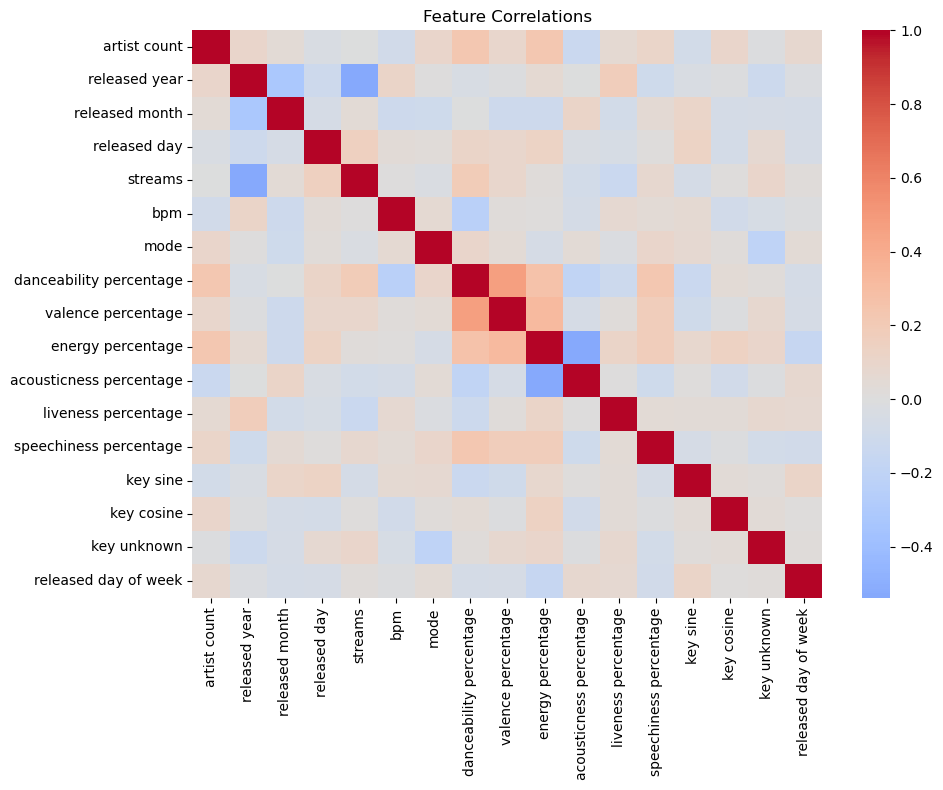

In [965]:
def draw_correlation_matrix(dataset: pd.DataFrame) -> None:
    """
    This function draws a correlation matrix heatmap for the given dataset.

    Parameters:
    dataset (DataFrame): The dataset to be used for drawing the correlation matrix heatmap.

    Returns:
    None
    """
    numerical_data = dataset.select_dtypes(include=['number'])
    
    # Vẽ biểu đồ heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(numerical_data.corr(), annot=False, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

draw_correlation_matrix(train_set)

From observation, some features can be seen as suitable predictors, since its correlation coefficient with `streams` is larger than 0. Those features are:
- `artist count`
- `released day of week`
- `released month`
- `released day`
- `danceability percentage`
- `valence percentage`
- `speechiness percentage`
- `key cosine`
- `key unknown`

In [966]:
columns_to_drop = [
    'released year',
    'bpm',
    'mode',
    'energy percentage',
    'acousticness percentage',
    'liveness percentage',
    'key sine',
]

train_set = train_set.drop(columns=columns_to_drop)

In [967]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               248 non-null    object 
 1   artist(s) name           248 non-null    object 
 2   artist count             248 non-null    int64  
 3   released month           248 non-null    int64  
 4   released day             248 non-null    int64  
 5   streams                  248 non-null    float64
 6   danceability percentage  248 non-null    float64
 7   valence percentage       248 non-null    float64
 8   speechiness percentage   248 non-null    float64
 9   key cosine               248 non-null    float64
 10  key unknown              248 non-null    float64
 11  released day of week     248 non-null    int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 23.4+ KB


# Further analysis into the data to answer questions

## How released day of week affects the number of streams?

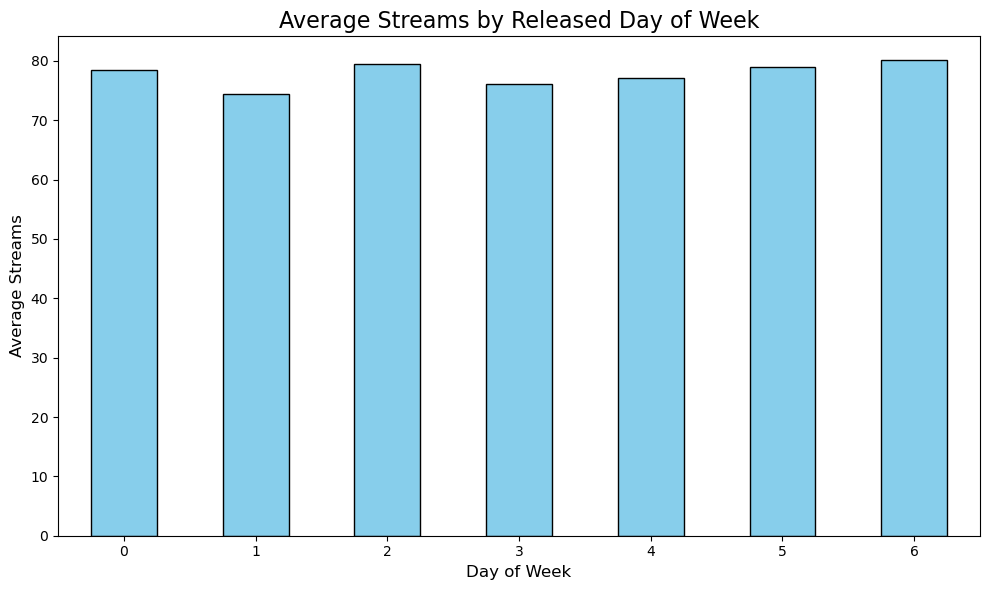

In [968]:
day_of_week_avg_streams = train_set.groupby('released day of week')['streams'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
day_of_week_avg_streams.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Streams by Released Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Streams', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## How released date (day/month) affects the number of streams?

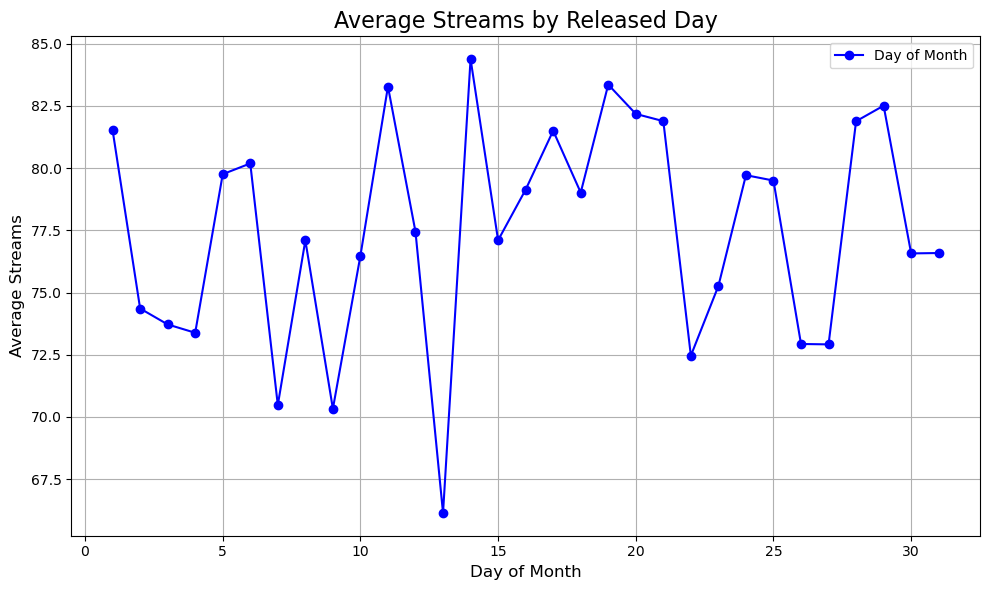

In [969]:
day_avg_streams = train_set.groupby('released day')['streams'].mean()
plt.figure(figsize=(10, 6))
day_avg_streams.plot(kind='line', marker='o', color='blue', label='Day of Month')
plt.title('Average Streams by Released Day', fontsize=16)
plt.xlabel('Day of Month', fontsize=12)
plt.ylabel('Average Streams', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1. The number of streams fluctuates strongly, especially around the middle of the month, but especially decreases on days near the middle of the month but peaks in the middle of the month.  
2. This shows that stream volume tends to be high at the beginning and end of the month
3. Maybe it's because during those times, people need to use music more (partying, reducing stress).

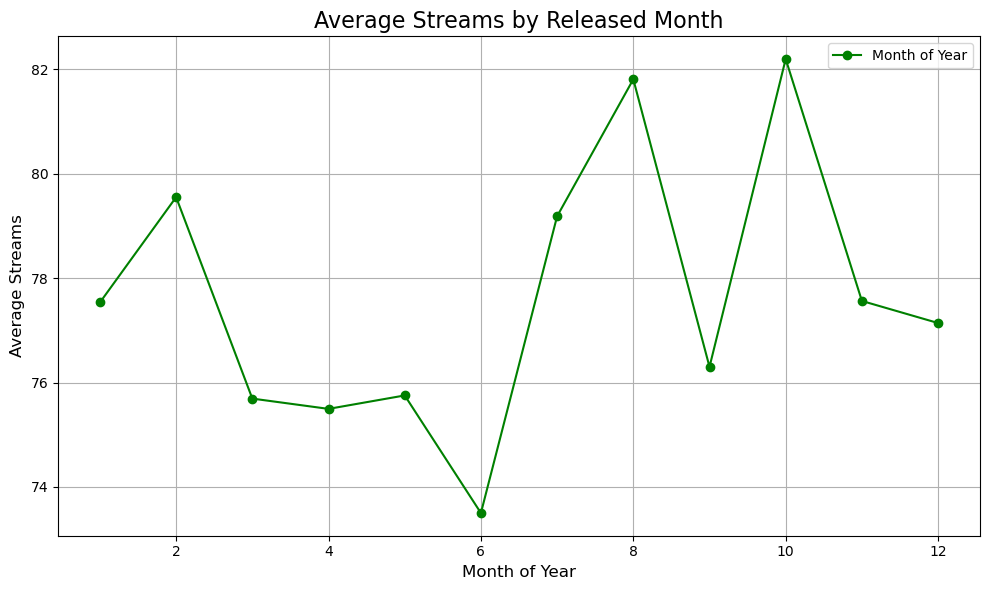

In [970]:
month_avg_streams = train_set.groupby('released month')['streams'].mean()
plt.figure(figsize=(10, 6))
month_avg_streams.plot(kind='line', marker='o', color='green', label='Month of Year')
plt.title('Average Streams by Released Month', fontsize=16)
plt.xlabel('Month of Year', fontsize=12)
plt.ylabel('Average Streams', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1. The number of streams at the beginning and end of the year tends to be high on average, coinciding with occasions such as traditional New Year and Christmas, leading to people tending to listen to a lot of music.
2. The number of streams in the middle of the year (June and July) is low because this is summer, people want to travel and explore a lot, so the time for music is reduced.
3. Then around August, streams tend to peak, this coincides with the end of summer and the time students start going back to school, which is also when a large number of listeners increase, showing that students students can contribute a large amount to the stream

## How key of a song affect the numbers of streams?

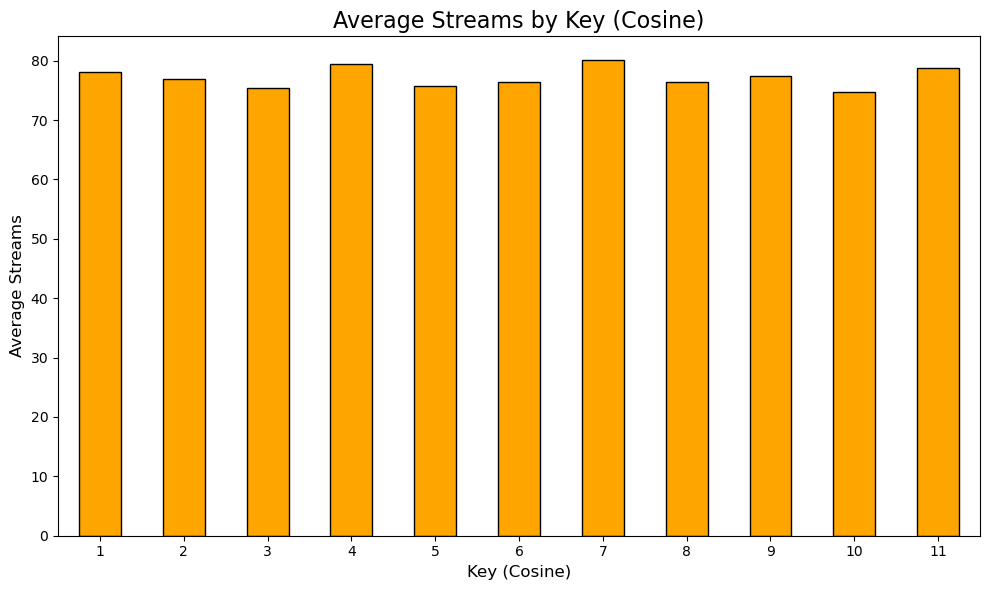

In [971]:
key_avg_streams = train_set.groupby('key cosine')['streams'].mean()
labels = range(1, len(key_avg_streams) + 1)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
key_avg_streams.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Streams by Key (Cosine)', fontsize=16)
plt.xlabel('Key (Cosine)', fontsize=12)
plt.ylabel('Average Streams', fontsize=12)
plt.xticks(ticks=range(len(key_avg_streams)), labels=labels, rotation=0)
plt.tight_layout()
plt.show()

1. There is a difference between the ''key cosines'' but it is not significant.
2. Showing that the ''key cosine'' is not a very important factor affecting the stream.

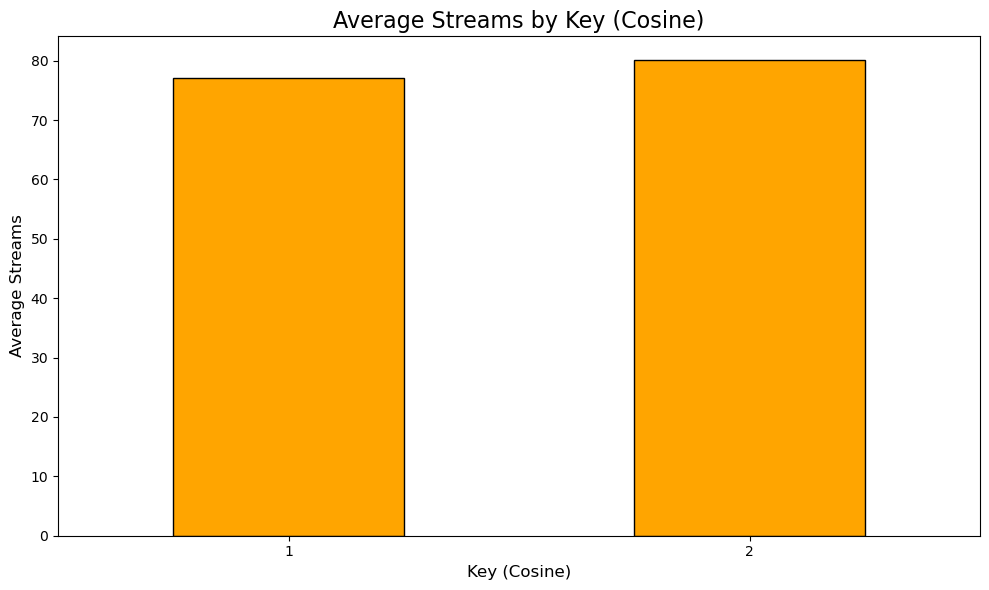

In [972]:
key_avg_streams = train_set.groupby('key unknown')['streams'].mean()
labels = range(1, len(key_avg_streams) + 1)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
key_avg_streams.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Average Streams by Key (Cosine)', fontsize=16)
plt.xlabel('Key (Cosine)', fontsize=12)
plt.ylabel('Average Streams', fontsize=12)
plt.xticks(ticks=range(len(key_avg_streams)), labels=labels, rotation=0)
plt.tight_layout()
plt.show()

1. There is a difference between the ''key unknown'' but it is not significant.
2. Showing that the ''key unknown'' is not a very important factor affecting the stream.

## How does a song's popularity vary with artist count?

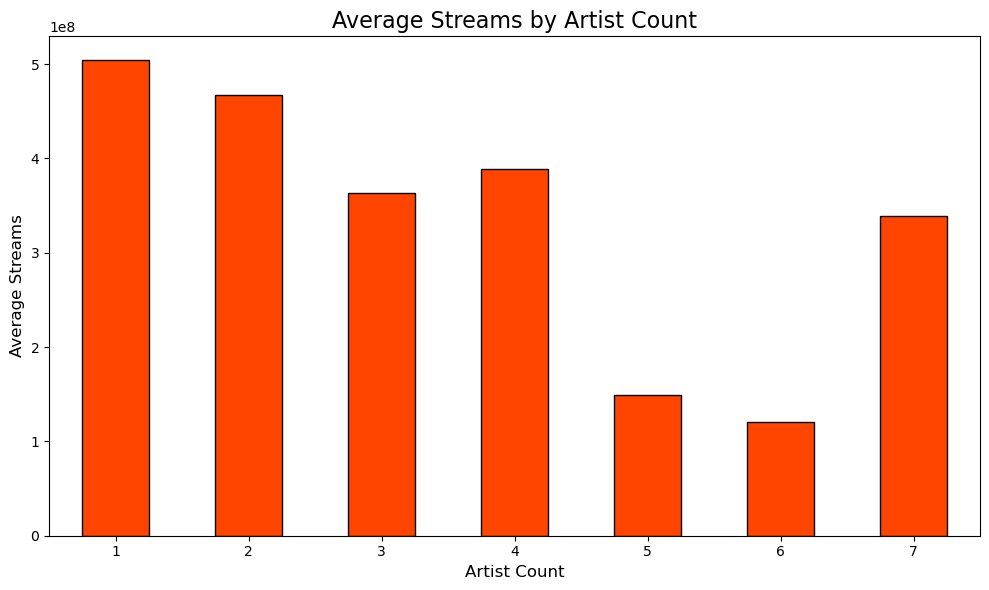

In [999]:
artist_count_avg_streams = train_set.groupby('artist count')['streams'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
artist_count_avg_streams.plot(kind='bar', color='#ff4500', edgecolor='black')
plt.title("Average Streams by Artist Count", fontsize=16)
plt.xlabel("Artist Count", fontsize=12)
plt.ylabel("Average Streams", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


1. We see that solo artists still have high streams, along with duets. 
2. We see that if there are more artists performing, the number of streams tends to decrease. Maybe because the listener files don't like their favorite singers being occupied by other singers. 

# Phase 5: Modeling

In [898]:
raw_test_set = pd.read_csv(f"{raw_data_path}/test_set.csv")
test_set = clean_test_set(raw_test_set, standard_scaler, corr_lambda)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               477 non-null    object 
 1   artist(s) name           477 non-null    object 
 2   artist count             477 non-null    int64  
 3   released month           477 non-null    int64  
 4   released day             477 non-null    int64  
 5   streams                  477 non-null    float64
 6   danceability percentage  477 non-null    float64
 7   valence percentage       477 non-null    float64
 8   speechiness percentage   477 non-null    float64
 9   key cosine               477 non-null    float64
 10  key unknown              477 non-null    float64
 11  released day of week     477 non-null    int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 44.8+ KB


/home/van/audio-pop-corr-analysis/notebooks/package.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('minor', 2))


Correlation matrix for test set is pretty bad.

In [ ]:
#train_set=train_set.drop(columns=['energy percentage', 'liveness percentage','key unknown','bpm','mode','acousticness percentage','key sine'])
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   track name               477 non-null    object 
 1   artist(s) name           477 non-null    object 
 2   artist count             477 non-null    int64  
 3   released month           477 non-null    int64  
 4   released day             477 non-null    int64  
 5   streams                  477 non-null    float64
 6   danceability percentage  477 non-null    float64
 7   valence percentage       477 non-null    float64
 8   speechiness percentage   477 non-null    float64
 9   key cosine               477 non-null    float64
 10  key unknown              477 non-null    float64
 11  released day of week     477 non-null    int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 44.8+ KB


## Fitting models

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

X_train = train_set.drop(columns=['streams', 'track name', 'artist(s) name'])  # X_train từ train_set
y_train = train_set['streams']  # y_train từ train_set

X_test = test_set.drop(columns=['streams', 'track name', 'artist(s) name'])  # X_test từ test_set
y_test = test_set['streams']  # y_test từ test_set

# Sử dụng GridSearchCV để tìm alpha tốt nhất
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Các giá trị alpha để thử nghiệm
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_ridge_model = grid_search.best_estimator_
print("Best alpha:", grid_search.best_params_)

# Dự đoán và đánh giá
y_pred = best_ridge_model.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred)
r21 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse1)
print("R-squared (R²):", r21)

Best alpha: {'alpha': 100}
Mean Squared Error (MSE): 190.80203490180833
R-squared (R²): -0.2642426133364124


In [888]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and validation sets
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Create the model
gbr = GradientBoostingRegressor(random_state=50)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5, 
    verbose=0,
    n_jobs=-1  
)


grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (negative MSE):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred)
print("Test Set MSE:", mse2)
r22 = r2_score(y_test, y_pred)
print("R-squared (R²):",r22)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 1.0}
Best Score (negative MSE): -71.39497645701063
Test Set MSE: 184.18703405050132
R-squared (R²): -0.2204120222854169


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor
rf = RandomForestRegressor(random_state=50)

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
print("Random Forest Best Parameters:", rf_grid_search.best_params_)
print("Random Forest Best Score (negative MSE):", rf_grid_search.best_score_)
rf_best_model = rf_grid_search.best_estimator_
rf_y_pred = rf_best_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print("Random Forest Test Set MSE:", rf_mse)
print("Random Forest R-squared (R²):", rf_r2)

Random Forest Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best Score (negative MSE): -72.87866793859332
Random Forest Test Set MSE: 185.7515311409474
Random Forest R-squared (R²): -0.23077828431821246


In [ ]:
joblib.dump(best_ridge_model, 'Ridge.pkl')

joblib.dump(best_model, 'Gradient_Boosting.pkl')

joblib.dump(best_model, 'Random_Forest.pkl')

['Random_Forest.pkl']

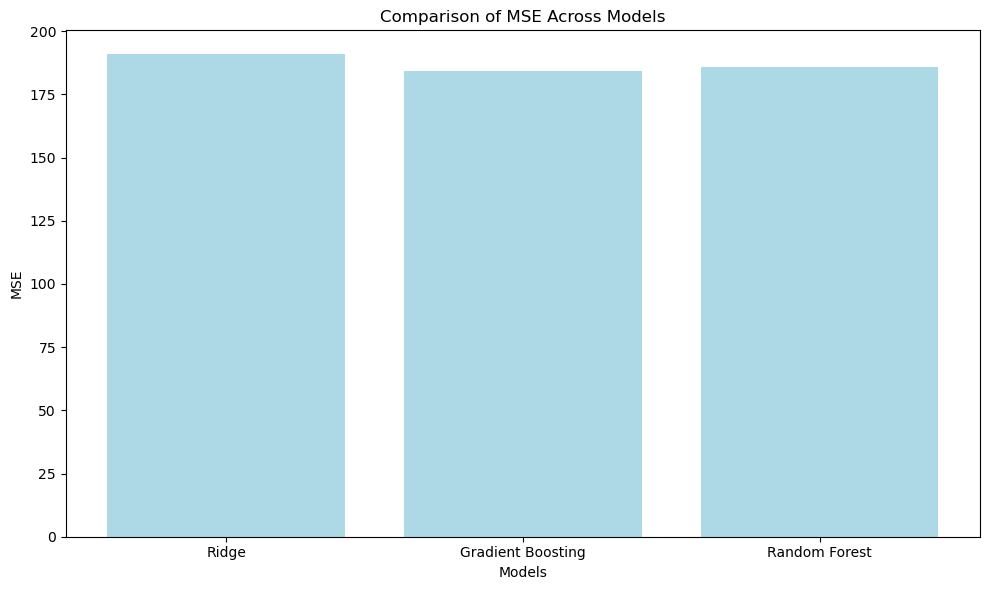

In [901]:
models = ['Ridge', 'Gradient Boosting', 'Random Forest']
mse_values = [mse1, mse2, rf_mse]  # Giá trị MSE của 3 model
r2_values = [r21, r22, rf_r2]  # Giá trị R² của 3 model

# Tạo biểu đồ để so sánh
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color='lightblue')
plt.title('Comparison of MSE Across Models')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.tight_layout()
plt.show()

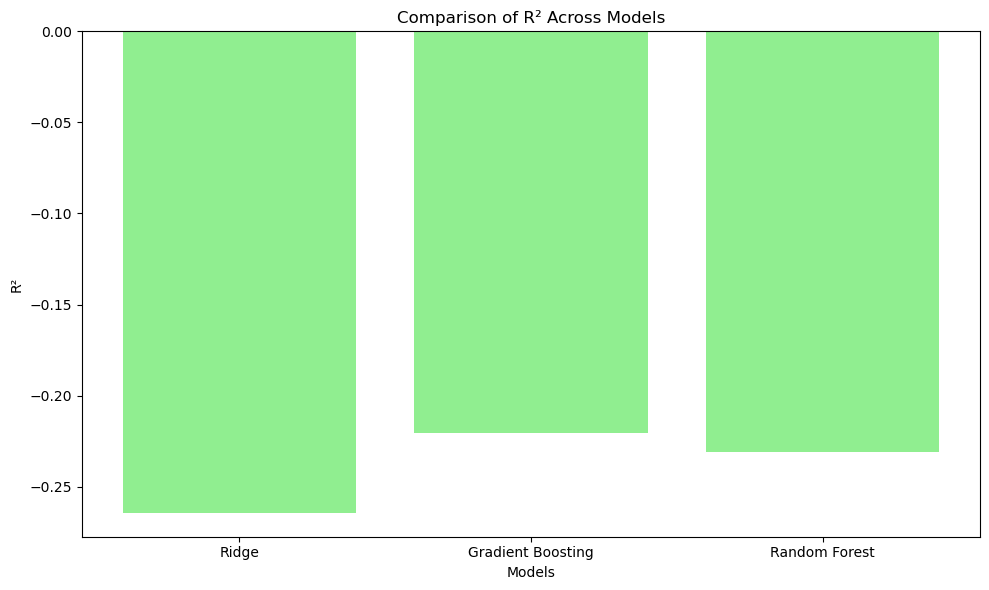

In [ ]:
# Vẽ biểu đồ cho R²
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen')
plt.title('Comparison of R² Across Models')
plt.xlabel('Models')
plt.ylabel('R²')
plt.tight_layout()
plt.show()

## Evaluating